In [ ]:
# Importar librerias
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
from sklearn.impute import SimpleImputer
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

import warnings
warnings.filterwarnings('ignore')

Autores: 
- Fredy A. Ramírez M.
- Fernando Berrocal Vergara


# Lectura de datos

In [2]:
data_train = pd.read_csv('./data/housing_train.csv', sep=',')
data_test = pd.read_csv('./data/housing_test.csv', sep=',')

In [3]:
# Se utilizaran los datos de train para el ejercicio ya que son los que tienen la variable SalePrice
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Preprocesamiento de los datos

## Revisar registros duplicados exactos

In [4]:
# Analisis de registros duplicados exactos
print('Número de duplicados:', data_train.duplicated().sum())

Número de duplicados: 0


## Corrección del tipo de datos

In [5]:
# Corregir el tipo de dato de las columnas al iterar sobre ellas
for col in data_train.columns:
    if data_train[col].dtype == 'object': # object es un tipo de dato texto
        data_train[col] = data_train[col].astype('category')
    else:
        data_train[col] = data_train[col].astype(float)

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   float64 
 1   MSSubClass     1460 non-null   float64 
 2   MSZoning       1460 non-null   category
 3   LotFrontage    1201 non-null   float64 
 4   LotArea        1460 non-null   float64 
 5   Street         1460 non-null   category
 6   Alley          91 non-null     category
 7   LotShape       1460 non-null   category
 8   LandContour    1460 non-null   category
 9   Utilities      1460 non-null   category
 10  LotConfig      1460 non-null   category
 11  LandSlope      1460 non-null   category
 12  Neighborhood   1460 non-null   category
 13  Condition1     1460 non-null   category
 14  Condition2     1460 non-null   category
 15  BldgType       1460 non-null   category
 16  HouseStyle     1460 non-null   category
 17  OverallQual    1460 non-null   fl

In [7]:
data_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.00,60.00,RL,65.00,8450.00,Pave,NaN,Reg,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,2.00,2008.00,WD,Normal,208500.00
1,2.00,20.00,RL,80.00,9600.00,Pave,NaN,Reg,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,5.00,2007.00,WD,Normal,181500.00
2,3.00,60.00,RL,68.00,11250.00,Pave,NaN,IR1,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,9.00,2008.00,WD,Normal,223500.00
3,4.00,70.00,RL,60.00,9550.00,Pave,NaN,IR1,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,2.00,2006.00,WD,Abnorml,140000.00
4,5.00,60.00,RL,84.00,14260.00,Pave,NaN,IR1,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,12.00,2008.00,WD,Normal,250000.00
5,6.00,50.00,RL,85.00,14115.00,Pave,NaN,IR1,Lvl,AllPub,...,0.00,NaN,MnPrv,Shed,700.00,10.00,2009.00,WD,Normal,143000.00
6,7.00,20.00,RL,75.00,10084.00,Pave,NaN,Reg,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,8.00,2007.00,WD,Normal,307000.00
7,8.00,60.00,RL,NaN,10382.00,Pave,NaN,IR1,Lvl,AllPub,...,0.00,NaN,NaN,Shed,350.00,11.00,2009.00,WD,Normal,200000.00
8,9.00,50.00,RM,51.00,6120.00,Pave,NaN,Reg,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,4.00,2008.00,WD,Abnorml,129900.00
9,10.00,190.00,RL,50.00,7420.00,Pave,NaN,Reg,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,1.00,2008.00,WD,Normal,118000.00


## Revisar porcentaje de datos faltantes

In [8]:
# Funcion para calcular el porcentaje de valores faltantes de cada columna
def porcentaje_faltantes(df):
    # Total de valores faltantes
    valores_faltantes = df.isna().sum()

    # Porcentaje de valores faltantes
    porcentaje = (valores_faltantes / len(df)) * 100

    # Tabla con valores faltantes
    tabla_faltantes = pd.concat([valores_faltantes, porcentaje], axis=1, keys=['Total', 'Porcentaje'])

    # Ordenar tabla de valores faltantes de mayor a menor
    tabla_faltantes = tabla_faltantes.sort_values(by='Porcentaje', ascending=False)

    return tabla_faltantes

In [9]:
tabla_valores_faltantes = porcentaje_faltantes(data_train)
tabla_valores_faltantes.head(20)

,Total,Porcentaje
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
MasVnrType,872,59.73
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55


In [10]:
# Descartar las columnas que tengan un porcentaje de valores faltantes mayor a 30%
listado_columnas_eliminadas = list(tabla_valores_faltantes[tabla_valores_faltantes['Porcentaje'] > 30].index)
listado_columnas_eliminadas

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']

In [11]:
data_train = data_train.drop(listado_columnas_eliminadas, axis=1)

## Imputacion de valores faltantes

In [12]:
# Eliminar columnas innecesarias
data_train = data_train.drop(columns=['Id'])

In [13]:
data_train.describe(exclude='category').T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.00,56.90,42.30,20.00,20.00,50.00,70.00,190.00
LotFrontage,1201.00,70.05,24.28,21.00,59.00,69.00,80.00,313.00
LotArea,1460.00,10516.83,9981.26,1300.00,7553.50,9478.50,11601.50,215245.00
OverallQual,1460.00,6.10,1.38,1.00,5.00,6.00,7.00,10.00
OverallCond,1460.00,5.58,1.11,1.00,5.00,5.00,6.00,9.00
YearBuilt,1460.00,1971.27,30.20,1872.00,1954.00,1973.00,2000.00,2010.00
YearRemodAdd,1460.00,1984.87,20.65,1950.00,1967.00,1994.00,2004.00,2010.00
MasVnrArea,1452.00,103.69,181.07,0.00,0.00,0.00,166.00,1600.00
BsmtFinSF1,1460.00,443.64,456.10,0.00,0.00,383.50,712.25,5644.00
BsmtFinSF2,1460.00,46.55,161.32,0.00,0.00,0.00,0.00,1474.00


In [14]:
# Obtener listado de variables numericas, con valores faltantes presentes, excepto SalesPrice
variables_numericas = data_train.select_dtypes(exclude='category').columns
variables_numericas = [var for var in variables_numericas if var != 'SalePrice']
variables_numericas_faltantes = [var for var in variables_numericas if data_train[var].isna().sum() > 0]

In [15]:
# Obtener listado de variables categoricas, con valores faltantes presentes
variables_categoricas = data_train.select_dtypes(include='category').columns
variables_categoricas_faltantes = [var for var in variables_categoricas if data_train[var].isna().sum() > 0]

In [16]:
variables_numericas_faltantes

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [17]:
variables_categoricas_faltantes

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [18]:
# Imputación por la media y moda

# Como solo una columna presenta un porcentaje de valores nulos significativo, se procede a imputar
# con metodos sencillos como la media y la moda

# Imputacion de variables numéricas
imp_numericas = SimpleImputer(missing_values=np.nan, strategy='mean')
data_train[variables_numericas_faltantes] = imp_numericas.fit_transform(data_train[variables_numericas_faltantes])

# Imputacion de variables categóricas
imp_categoricas = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_train[variables_categoricas_faltantes] = imp_categoricas.fit_transform(data_train[variables_categoricas_faltantes])

In [19]:
# Ya no se presentan valores faltantes
porcentaje_faltantes(data_train).head(10)

,Total,Porcentaje
MSSubClass,0,0.00
GarageYrBlt,0,0.00
Fireplaces,0,0.00
Functional,0,0.00
TotRmsAbvGrd,0,0.00
KitchenQual,0,0.00
KitchenAbvGr,0,0.00
BedroomAbvGr,0,0.00
HalfBath,0,0.00
FullBath,0,0.00


In [20]:
# Analisis de registros duplicados exactos
print('Número de duplicados:', data_train.duplicated().sum())

Número de duplicados: 0


# Selección de variables

## Variables numéricas

In [21]:
# Correlación en valor absoluto de cada variable numerica vs SalePrice
corr_abs_obj = data_train.corr(method='pearson', numeric_only=True)['SalePrice']
corr_abs_obj = abs(corr_abs_obj).sort_values(ascending=False)
corr_abs_obj.head(20)

SalePrice      1.00
OverallQual    0.79
GrLivArea      0.71
GarageCars     0.64
GarageArea     0.62
TotalBsmtSF    0.61
1stFlrSF       0.61
FullBath       0.56
TotRmsAbvGrd   0.53
YearBuilt      0.52
YearRemodAdd   0.51
MasVnrArea     0.48
GarageYrBlt    0.47
Fireplaces     0.47
BsmtFinSF1     0.39
LotFrontage    0.33
WoodDeckSF     0.32
2ndFlrSF       0.32
OpenPorchSF    0.32
HalfBath       0.28
Name: SalePrice, dtype: float64

In [22]:
# Se preservaran entonces las variables numericas con una correlacion absoluta con SalePrice mayor a 0.5
variables_numericas = list(corr_abs_obj[corr_abs_obj > 0.5].index)
variables_numericas = [var for var in variables_numericas if var != 'SalePrice']
variables_numericas

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd']

## Variables categóricas

In [23]:
# Observamos qué valores únicos presentan las variables
for col in variables_categoricas:
    print(f'{col} = {data_train[col].unique()}')

MSZoning = ['RL', 'RM', 'C (all)', 'FV', 'RH']
Categories (5, object): ['C (all)', 'FV', 'RH', 'RL', 'RM']
Street = ['Pave', 'Grvl']
Categories (2, object): ['Grvl', 'Pave']
LotShape = ['Reg', 'IR1', 'IR2', 'IR3']
Categories (4, object): ['IR1', 'IR2', 'IR3', 'Reg']
LandContour = ['Lvl', 'Bnk', 'Low', 'HLS']
Categories (4, object): ['Bnk', 'HLS', 'Low', 'Lvl']
Utilities = ['AllPub', 'NoSeWa']
Categories (2, object): ['AllPub', 'NoSeWa']
LotConfig = ['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3']
Categories (5, object): ['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside']
LandSlope = ['Gtl', 'Mod', 'Sev']
Categories (3, object): ['Gtl', 'Mod', 'Sev']
Neighborhood = ['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', ..., 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU', 'Blueste']
Length: 25
Categories (25, object): ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', ..., 'Somerst', 'StoneBr', 'Timber', 'Veenker']
Condition1 = ['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA', 'RRNe']
Catego

In [24]:
# A continuación se muestra un listado de las variables categóricas
# y un conteo de sus valores y frecuencias
data_train.loc[:, data_train.columns.isin(variables_categoricas)].describe().T

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260
Condition2,1460,8,Norm,1445


Se validará si hay diferencias significativas con respecto a la variable objetivo entre los diferentes grupos de las variables categoricas 

H0 = La diferencia entre las medias de los grupos es 0 (No hay diferencia significativa entre los grupos)

H1 = La diferencia entre las medias de los grupos es diferente de 0 (Existe diferencia significativa entre los grupos)

In [25]:
# Se aplica análisis ANOVA para descartar variables categoricas no significativas
# para la prediccion de la variable objetivo
def anova_test(df, target, feature):
  df_anova = df[[feature, target]]
  grps = pd.unique(df[feature].values)
  d_data = {grp:df_anova[target][df_anova[feature] == grp].to_numpy() for grp in grps}
  result = ""
  test_grps = [d_data[grp] for grp in grps]
  F, p = stats.f_oneway(*test_grps)
  
  if p > 0.05:
  #    print("reject null hypothesis")
  #    result="{0} groups' are different".format(feature)
  #    print(result)
  #else:
    print("p-value for significance is: ", p)
    print("accept null hypothesis")
    result="{0} groups' are not different".format(feature)
    print(result)
    print('-'*50)

In [26]:
# Se realiza la prueba para cada variable numérica y se encuentra que las
# siguientes NO son significativas
for var in variables_categoricas:
    anova_test(data_train, 'SalePrice', var)

p-value for significance is:  0.1170486040678794
accept null hypothesis
Street groups' are not different
--------------------------------------------------
p-value for significance is:  0.5847167739687491
accept null hypothesis
Utilities groups' are not different
--------------------------------------------------
p-value for significance is:  0.14139635841153894
accept null hypothesis
LandSlope groups' are not different
--------------------------------------------------


Se observa que el valor medio de la variable objetivo es practicamente igual para cada valor de las variables categoricas NO significativas de acuerdo al test ANOVA

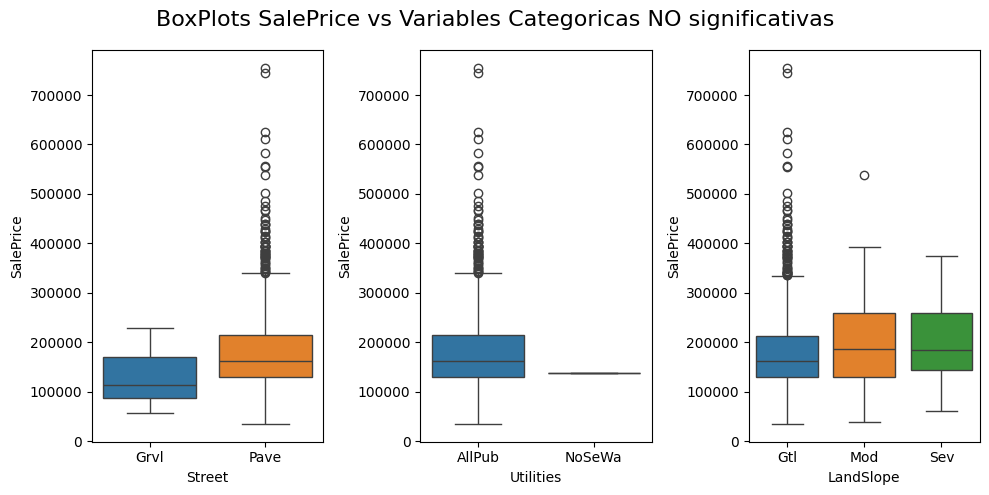

In [27]:
# Grafico de grilla de boxplot para tres variables categoricas

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

fig.suptitle('BoxPlots SalePrice vs Variables Categoricas NO significativas', fontsize=16)

for i, var in enumerate(['Street', 'Utilities', 'LandSlope']):
    sns.boxplot(ax=axes[i], data=data_train, x=var, y='SalePrice', hue=var)
    plt.xlabel(var)
    plt.ylabel('SalePrice')
    plt.tight_layout()

In [28]:
# Actualizar variables categoricas
variables_categoricas = [var for var in variables_categoricas if var not in ['Street', 'Utilities', 'LandSlope']]
variables_categoricas

['MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

## Depurar dataset con variables seleccionadas

In [29]:
# Finalmente se conservan las variables numericas y categoricas significativas ademas de SalePrice
cols_preservar = variables_numericas + variables_categoricas + ['SalePrice']
data_train = data_train[cols_preservar]
data_train.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,7.00,1710.00,2.00,548.00,856.00,856.00,2.00,8.00,2003.00,2003.00,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,208500.00
1,6.00,1262.00,2.00,460.00,1262.00,1262.00,2.00,6.00,1976.00,1976.00,...,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,181500.00
2,7.00,1786.00,2.00,608.00,920.00,920.00,2.00,6.00,2001.00,2002.00,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,223500.00
3,7.00,1717.00,3.00,642.00,756.00,961.00,1.00,7.00,1915.00,1970.00,...,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml,140000.00
4,8.00,2198.00,3.00,836.00,1145.00,1145.00,2.00,9.00,2000.00,2000.00,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,250000.00


# Análisis exploratorio

## Variables numericas

Una vez teniendo variables predictoras significativas, se realiza un EDA

<Axes: >

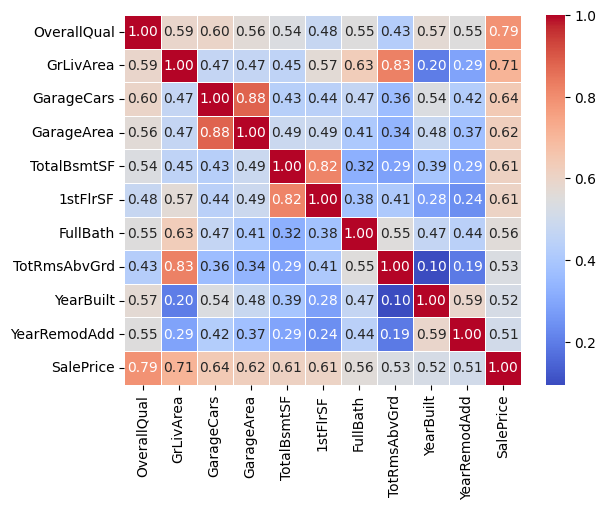

In [30]:
sns.heatmap(data_train.corr(method='pearson', numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm', linewidth=.5)

In [31]:
# Se observa presencia de multicoolinealidad entre las variables numericas predictoras
# En cada pareja donde la correlacion es mayor a 0.7, se considera multicollinealidad

# Se elimina, de cada par, la que menor correlacion tiene con SalePrice
variables_numericas_eliminar = ['GarageArea', 'TotRmsAbvGrd', '1stFlrSF']
data_train = data_train.drop(columns=variables_numericas_eliminar)

<Axes: >

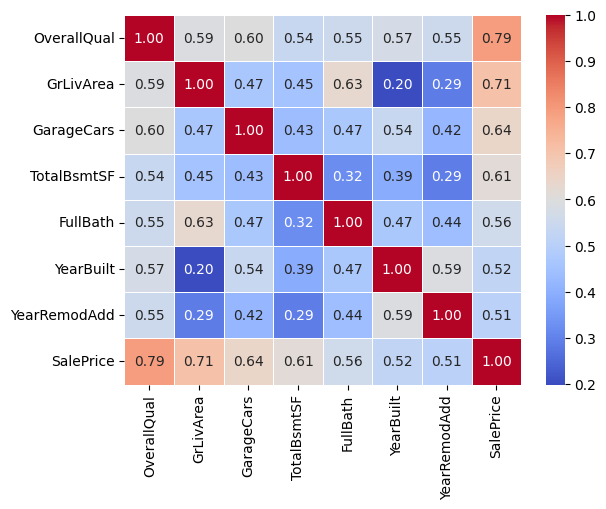

In [32]:
# Se observa que las correlaciones entre las variables numericas restantes son menores a 0.7
sns.heatmap(data_train.corr(method='pearson', numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm', linewidth=.5)

In [33]:
# Actualizar variables numericas
variables_numericas = [var for var in variables_numericas if var not in variables_numericas_eliminar]
variables_numericas

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 'FullBath',
 'YearBuilt',
 'YearRemodAdd']

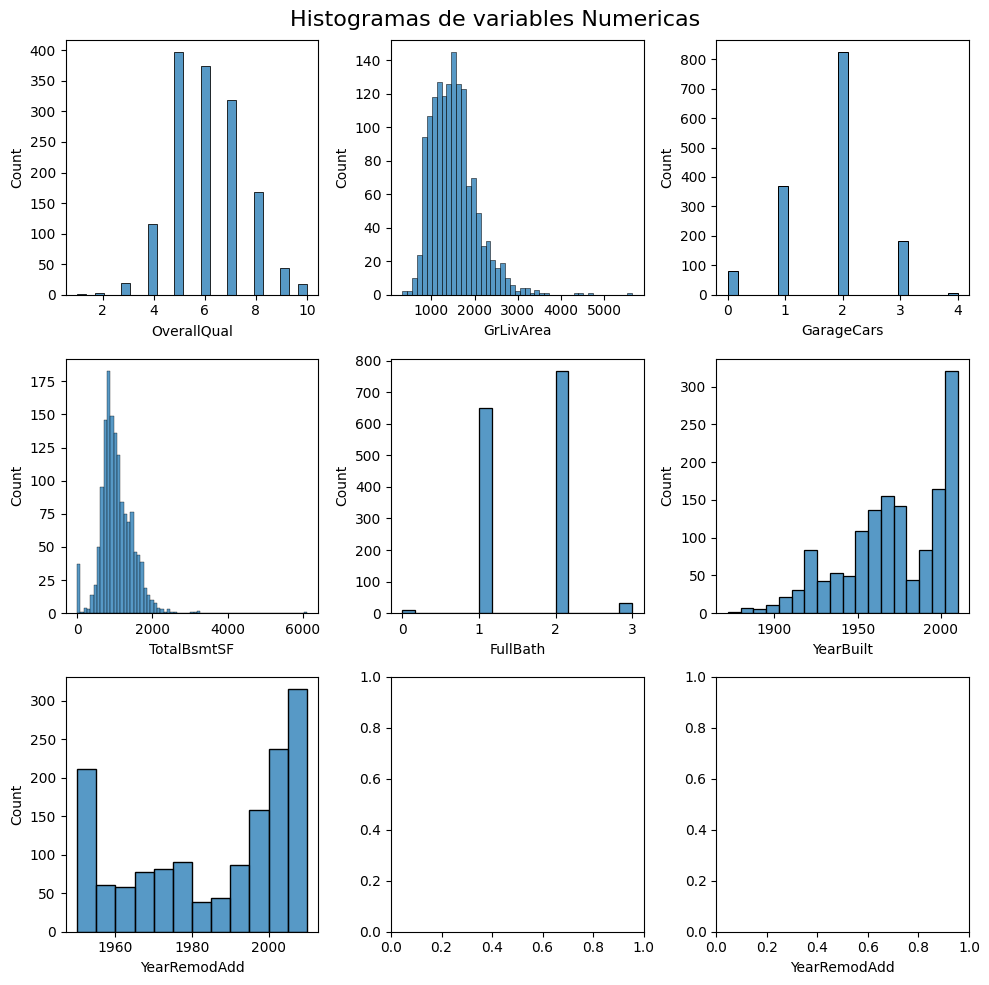

In [34]:
# Grafico de grilla de histogramas  de las variables numericas

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

fig.suptitle('Histogramas de variables Numericas', fontsize=16)

for i, var in enumerate(variables_numericas):
    sns.histplot(ax=axes[i//3, i%3], data=data_train, x=var, kde=False)
    plt.xlabel(var)
    plt.tight_layout()

Se aprecia que la mayoria de construcciones se hicieron a partir de la decada de 1960. Se observan algunos valores atipicos

In [35]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
OverallQual,1460.00,6.10,1.38,1.00,5.00,6.00,7.00,10.00
GrLivArea,1460.00,1515.46,525.48,334.00,1129.50,1464.00,1776.75,5642.00
GarageCars,1460.00,1.77,0.75,0.00,1.00,2.00,2.00,4.00
TotalBsmtSF,1460.00,1057.43,438.71,0.00,795.75,991.50,1298.25,6110.00
FullBath,1460.00,1.57,0.55,0.00,1.00,2.00,2.00,3.00
YearBuilt,1460.00,1971.27,30.20,1872.00,1954.00,1973.00,2000.00,2010.00
YearRemodAdd,1460.00,1984.87,20.65,1950.00,1967.00,1994.00,2004.00,2010.00
SalePrice,1460.00,180921.20,79442.50,34900.00,129975.00,163000.00,214000.00,755000.00


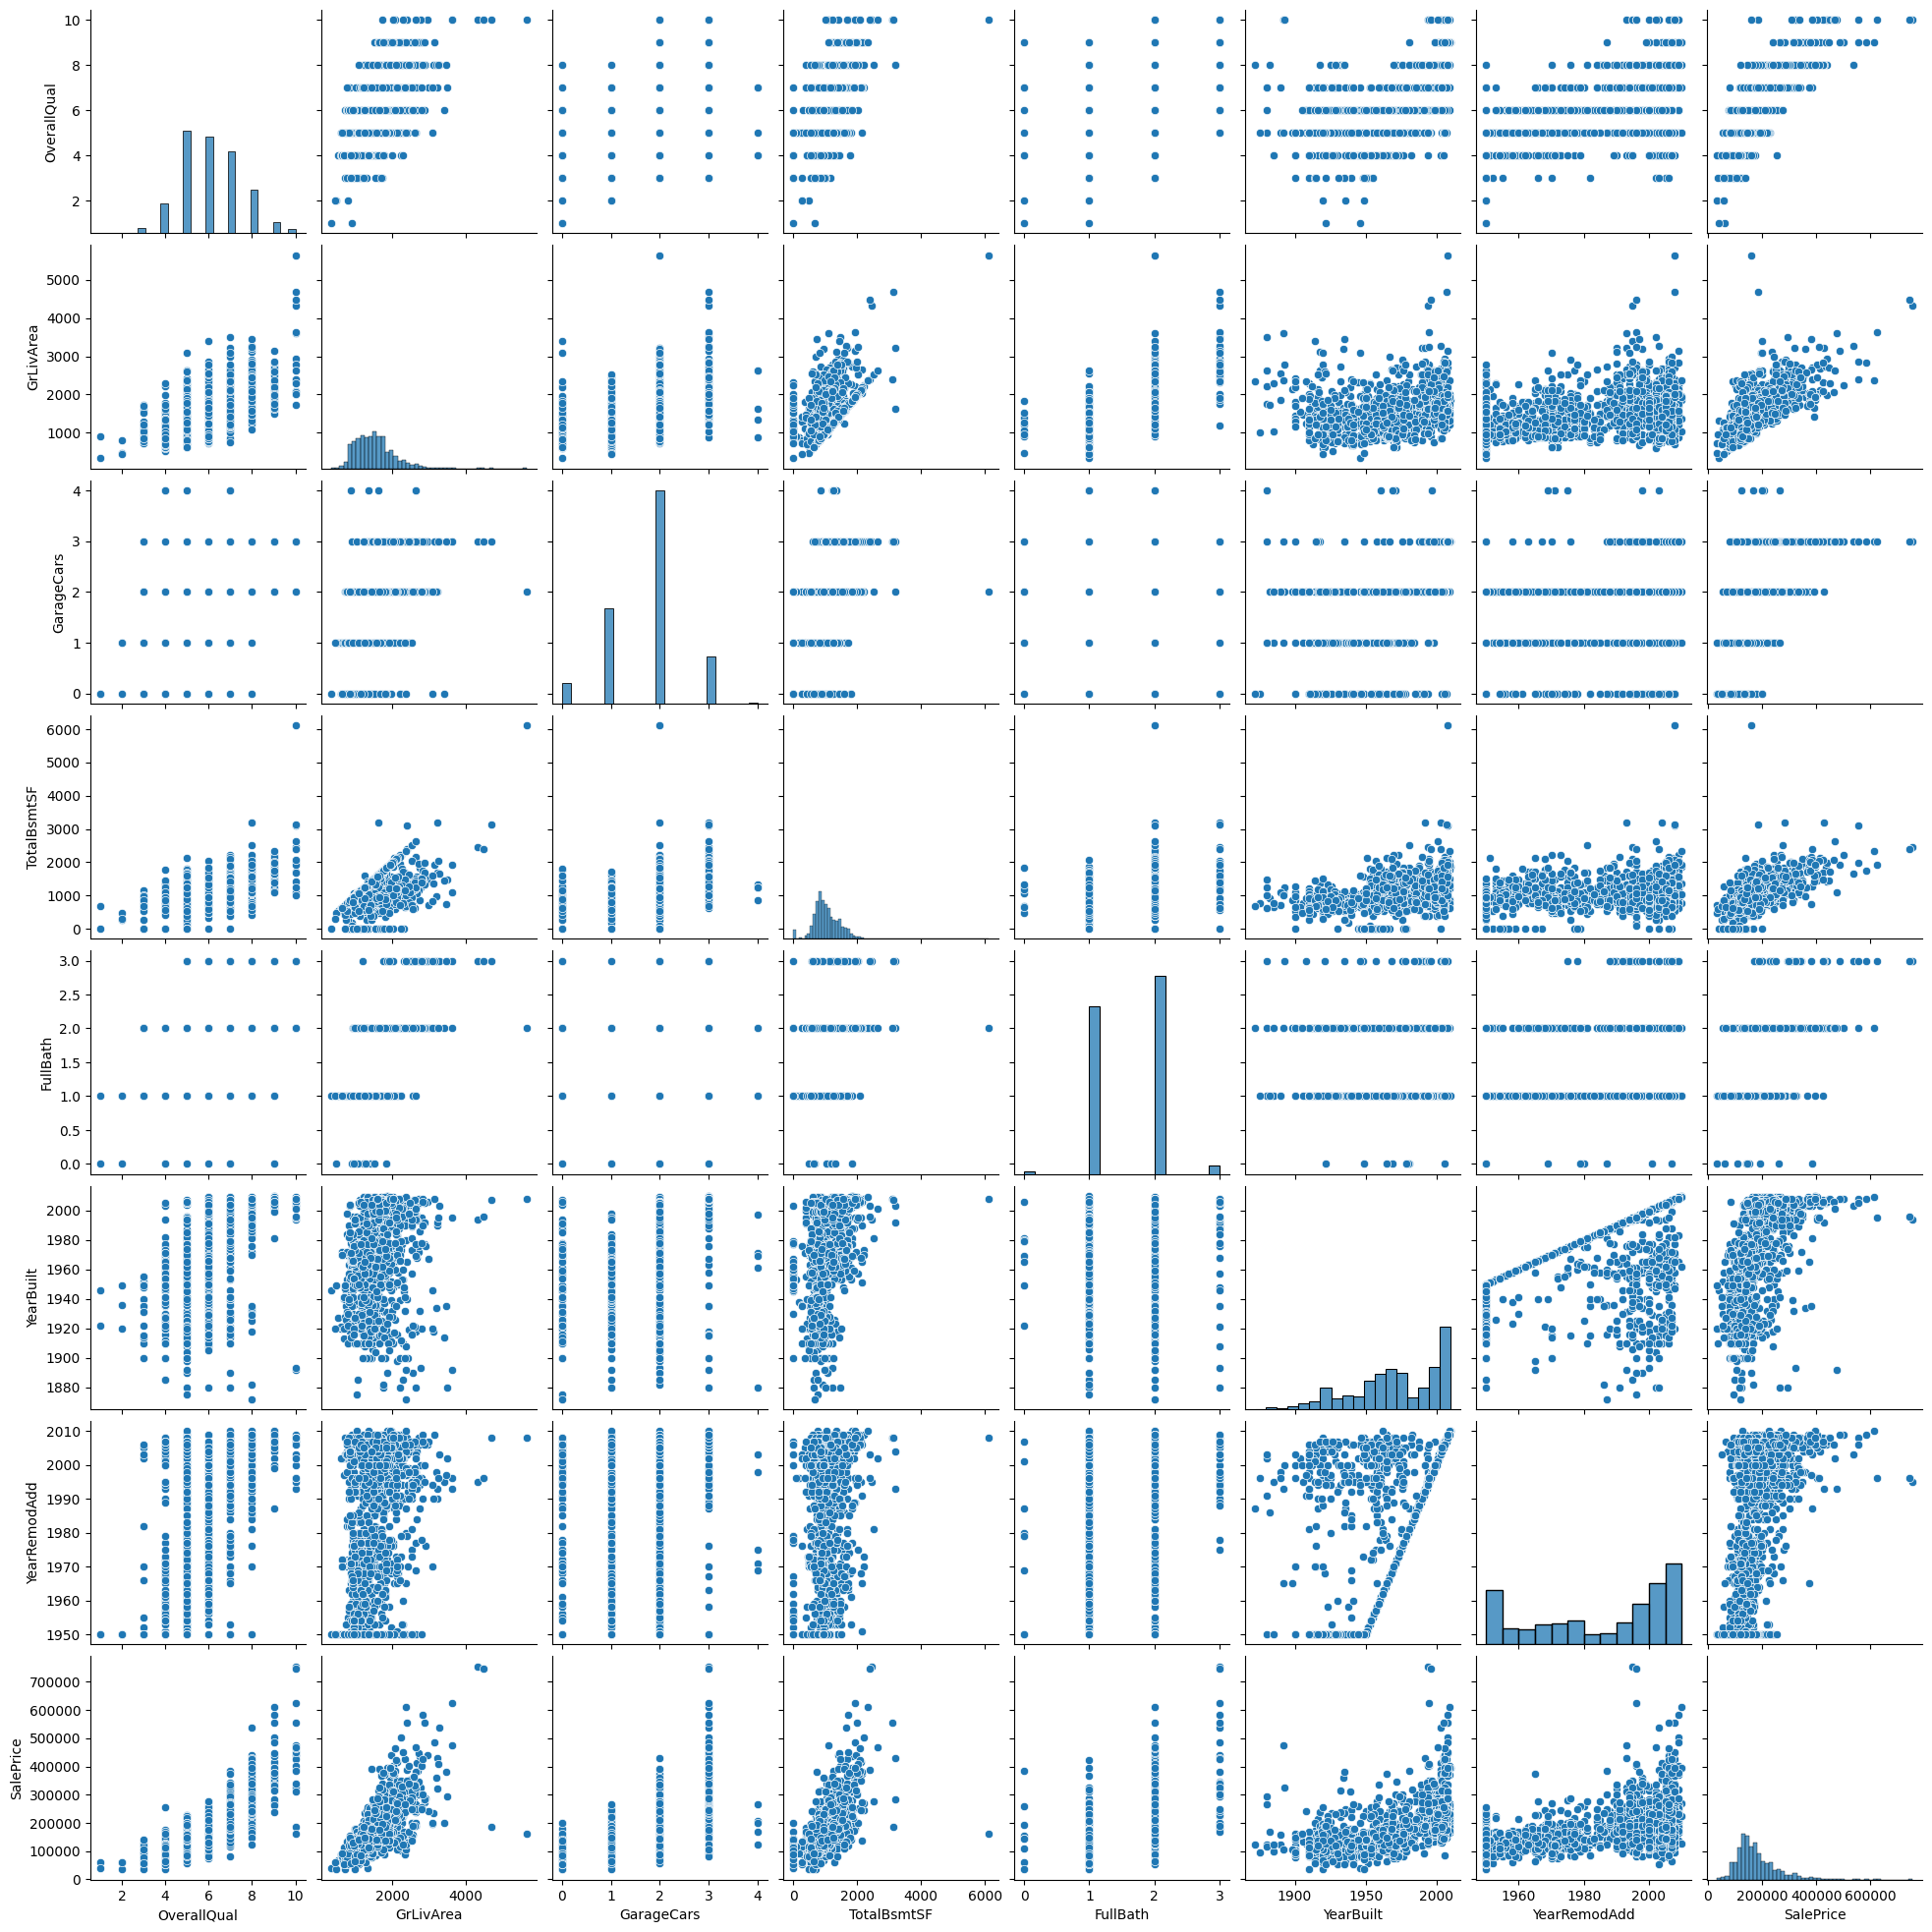

In [36]:
# Pairplot de todas las variables numericas
sns.pairplot(data_train)

Se observa que hay aparentes relaciones lineales entre las variables numericas y SalePrice

### Detección de valores atípicos

In [37]:
def detectar_atipicos(df: pd.DataFrame, variable: pd.Series):
    '''
    Calcula los valores limite para detectar atípicos en la variable especificada del dataframe
    
    Args:
        df (DataFrame): Dataframe con los datos
        variable (Series): Columna a la cual se la hará la detección de atípicos

    Retorna:
        tuple: Una tupla con los valores limites para detectar atípicos
    '''
    # Se definnen como atípicos los datos por fuera del rango intercuartilico
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3 - q1
    lim_superior = q3 + 1.5 * iqr
    lim_inferior = q1 - 1.5 * iqr
    return (lim_inferior, lim_superior)


def reemplazar_atipicos(df: pd.DataFrame, variable: pd.Series):
    '''
    Reemplaza los datos atípicos de la columna especificada con los valores limites
    
    Args:
        df (DataFrame): Dataframe con los datos
        variable (Series): Columna a la cual se la hará la detección de atípicos

    Retorna:
        DataFrame: Dataframe que incluye la columna especificada sin datos atípicos
    '''
    lim_inferior, lim_superior = detectar_atipicos(df, variable)
    df.loc[(df[variable] < lim_inferior), variable] = lim_inferior
    df.loc[(df[variable] > lim_superior), variable] = lim_superior
    return df

In [38]:
# Se aplica la deteccion de atipicos en la columna susceptible a presentarlos
for col in variables_numericas:
    data_train = reemplazar_atipicos(data_train, col)

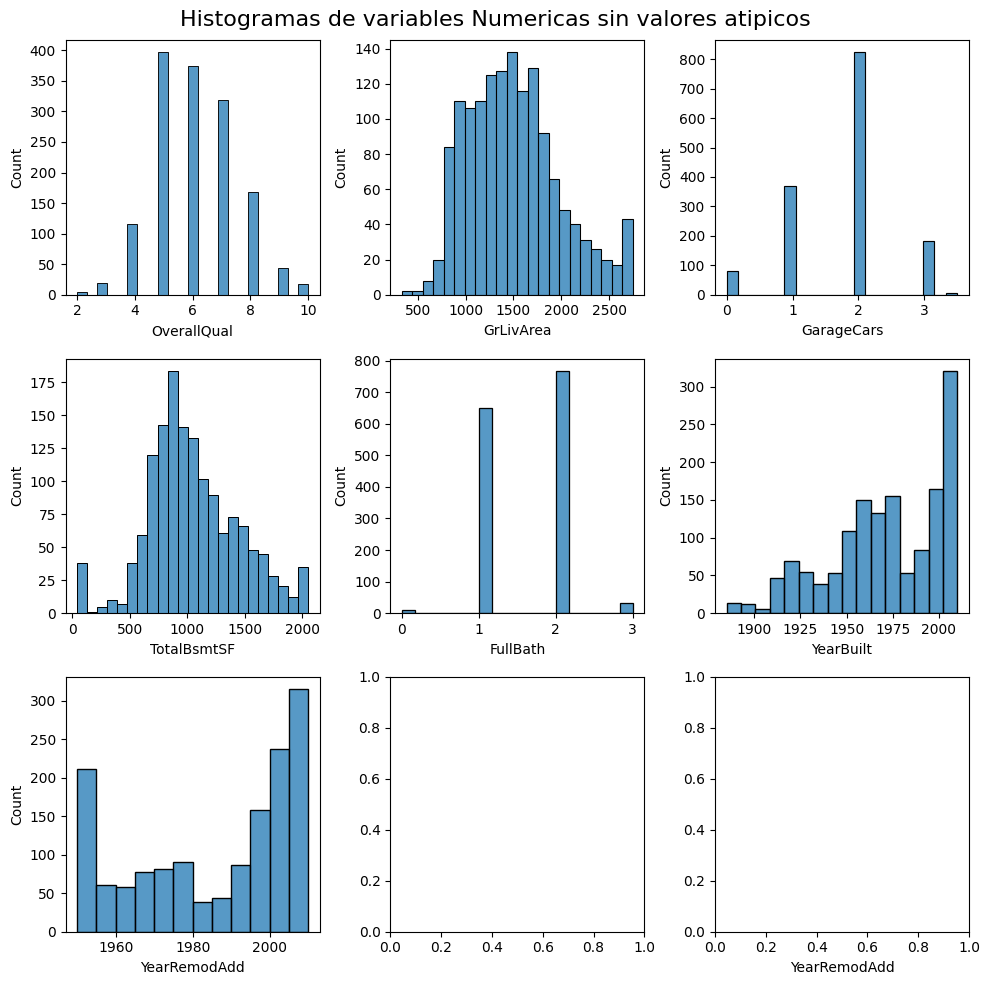

In [39]:
# Grafico de grilla de histogramas  de las variables numericas

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

fig.suptitle('Histogramas de variables Numericas sin valores atipicos', fontsize=16)

for i, var in enumerate(variables_numericas):
    sns.histplot(ax=axes[i//3, i%3], data=data_train, x=var, kde=False)
    plt.xlabel(var)
    plt.tight_layout()

## Variables categoricas

In [40]:
# A continuación se muestra un listado de las variables categóricas
# y un conteo de sus valores y frecuencias
data_train.loc[:, data_train.columns.isin(variables_categoricas)].describe().T

,count,unique,top,freq
MSZoning,1460,5,RL,1151
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
LotConfig,1460,5,Inside,1052
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260
Condition2,1460,8,Norm,1445
BldgType,1460,5,1Fam,1220
HouseStyle,1460,8,1Story,726
RoofStyle,1460,6,Gable,1141


In [41]:
# Resumen de promedio de SalePrice por categoria GarageType
data_train.groupby('GarageType')['SalePrice'].mean().sort_values()

GarageType
CarPort   109962.11
Detchd    134091.16
2Types    151283.33
Basment   160570.68
Attchd    194411.47
BuiltIn   254751.74
Name: SalePrice, dtype: float64

In [42]:
# Resumen de promedio de SalePrice por categoria HouseStyle
data_train.groupby('HouseStyle')['SalePrice'].mean().sort_values()

HouseStyle
1.5Unf   110150.00
SFoyer   135074.49
1.5Fin   143116.74
2.5Unf   157354.55
SLvl     166703.38
1Story   175985.48
2Story   210051.76
2.5Fin   220000.00
Name: SalePrice, dtype: float64

# Feature Engineering

## División de los datos

In [43]:
# El ajuste del encoder y el escaler se deben hacer con los datos de entrenamiento
X = data_train.drop('SalePrice', axis=1)
y = data_train['SalePrice']

In [44]:
# Division 70-30 de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Datos de entrenamiento

### Codificación de variables categóricas

In [45]:
# Se aplica el encoding a las variables categoricas
encoder = TargetEncoder(cols=variables_categoricas)
X_train[variables_categoricas] = encoder.fit_transform(X_train[variables_categoricas], y_train)

In [46]:
X_train

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,MSZoning,LotShape,LandContour,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
135,7.00,1682.00,2.00,1304.00,2.00,1970.00,1970.00,191179.18,166232.91,180203.53,...,186899.95,141930.01,184038.82,194562.95,138409.46,182662.66,183297.37,186561.17,174445.92,175518.38
1452,5.00,1072.00,2.00,547.00,1.00,2005.00,2005.00,127280.87,166232.91,180203.53,...,186899.95,141930.01,184038.82,175212.22,235882.49,182662.66,183297.37,186561.17,174445.92,175518.38
762,7.00,1547.00,2.00,756.00,2.00,2009.00,2009.00,211987.68,166232.91,180203.53,...,186899.95,211904.31,184038.82,194562.95,138409.46,182662.66,183297.37,186561.17,193836.34,175518.38
932,9.00,1905.00,3.00,1905.00,2.00,2006.00,2006.00,191179.18,203422.85,180203.53,...,186899.95,328883.19,184038.82,194562.95,235882.49,182662.66,183297.37,186561.17,174445.92,175518.38
435,7.00,1661.00,2.00,799.00,2.00,1996.00,1996.00,191179.18,221198.69,180203.53,...,186899.95,211904.31,184038.82,194562.95,204450.21,182662.66,183297.37,186561.17,176527.46,175518.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,6.00,1314.00,2.00,1314.00,2.00,2006.00,2006.00,191179.18,203422.85,180203.53,...,186899.95,211904.31,184038.82,194562.95,204450.21,182662.66,183297.37,186561.17,174445.92,175518.38
1130,4.00,1981.00,2.00,1122.00,2.00,1928.00,1950.00,191179.18,166232.91,180203.53,...,186899.95,211904.31,156611.83,136471.66,138409.46,182662.66,183297.37,186561.17,174445.92,175518.38
1294,5.00,864.00,2.00,864.00,1.00,1955.00,1990.00,191179.18,166232.91,180203.53,...,186899.95,141930.01,184038.82,136471.66,138409.46,182662.66,183297.37,118874.70,174445.92,175518.38
860,7.00,1426.00,1.00,912.00,1.00,1918.00,1998.00,191179.18,166232.91,180203.53,...,186899.95,211904.31,184038.82,136471.66,138409.46,182662.66,183297.37,186561.17,174445.92,175518.38


### Estandarización de los datos

In [ ]:
# Una vez aplicado el encoding se normalizan las variables para que tengan media 0 y desviación estandar 1
# y conserven la misma escala
scaler_train = PowerTransformer(method='yeo-johnson', standardize=True)
#scaler_train = StandardScaler()

In [48]:
X_train[X_train.columns] = scaler_train.fit_transform(X_train[X_train.columns])

In [49]:
X_train

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,MSZoning,LotShape,LandContour,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
135,0.66,0.45,0.25,0.64,0.78,-0.20,-0.86,0.25,-0.00,-0.00,...,0.30,-0.87,0.28,0.39,-1.04,0.04,0.18,0.30,-0.00,-0.00
1452,-0.82,-0.93,0.25,-1.27,-1.07,1.24,1.06,-1.96,-0.00,-0.00,...,0.30,-0.87,0.28,-0.24,1.24,0.04,0.18,0.30,-0.00,-0.00
762,0.66,0.18,0.25,-0.73,0.78,1.44,1.38,2.85,-0.00,-0.00,...,0.30,0.90,0.28,0.39,-1.04,0.04,0.18,0.30,0.00,-0.00
932,2.01,0.86,1.83,2.08,0.78,1.29,1.14,0.25,0.00,-0.00,...,0.30,1.83,0.28,0.39,1.24,0.04,0.18,0.30,-0.00,-0.00
435,0.66,0.41,0.25,-0.62,0.78,0.82,0.43,0.25,0.00,-0.00,...,0.30,0.90,0.28,0.39,0.64,0.04,0.18,0.30,-0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,-0.06,-0.32,0.25,0.67,0.78,1.29,1.14,0.25,0.00,-0.00,...,0.30,0.90,0.28,0.39,0.64,0.04,0.18,0.30,-0.00,-0.00
1130,-1.62,0.99,0.25,0.20,0.78,-1.35,-1.48,0.25,-0.00,-0.00,...,0.30,0.90,-3.85,-1.45,-1.04,0.04,0.18,0.30,-0.00,-0.00
1294,-0.82,-1.54,0.25,-0.45,-1.07,-0.67,0.07,0.25,-0.00,-0.00,...,0.30,-0.87,0.28,-1.45,-1.04,0.04,0.18,-3.31,-0.00,-0.00
860,0.66,-0.07,-1.10,-0.33,-1.07,-1.55,0.56,0.25,-0.00,-0.00,...,0.30,0.90,0.28,-1.45,-1.04,0.04,0.18,0.30,-0.00,-0.00


## Datos de prueba

### Codificación de variables categóricas

In [50]:
# Aplicar la misma codificación a los datos de test
X_test[variables_categoricas] = encoder.transform(X_test[variables_categoricas])

In [51]:
X_test

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,MSZoning,LotShape,LandContour,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
892,6.00,1068.00,1.00,1059.00,1.00,1963.00,2003.00,191179.18,166232.91,180203.53,...,186899.95,141930.01,184038.82,194562.95,204450.21,182662.66,183297.37,186561.17,174445.92,175518.38
1105,8.00,2622.00,2.00,1463.00,2.00,1994.00,1995.00,191179.18,203422.85,180203.53,...,186899.95,211904.31,184038.82,194562.95,204450.21,182662.66,183297.37,186561.17,174445.92,175518.38
413,5.00,1028.00,2.00,1008.00,1.00,1927.00,1950.00,127280.87,166232.91,180203.53,...,126560.80,141930.01,184038.82,136471.66,138409.46,182662.66,183297.37,186561.17,174445.92,175518.38
522,6.00,1664.00,2.00,1004.00,2.00,1947.00,1950.00,127280.87,166232.91,180203.53,...,186899.95,141930.01,184038.82,136471.66,138409.46,182662.66,183297.37,186561.17,174445.92,175518.38
1036,9.00,1620.00,3.00,1620.00,2.00,2007.00,2008.00,191179.18,203422.85,232419.05,...,186899.95,328883.19,184038.82,194562.95,235882.49,182662.66,183297.37,186561.17,174445.92,175518.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,5.00,1056.00,1.00,1056.00,1.00,1958.00,1992.00,191179.18,166232.91,180203.53,...,186899.95,141930.01,184038.82,194562.95,204450.21,182662.66,183297.37,186561.17,174445.92,175518.38
323,3.00,1163.00,1.00,1162.00,1.00,1955.00,2005.00,127280.87,166232.91,180203.53,...,186899.95,141930.01,184038.82,194562.95,138409.46,138421.34,183297.37,186561.17,174445.92,175518.38
650,7.00,1665.00,2.00,813.00,2.00,2007.00,2007.00,211987.68,166232.91,180203.53,...,186899.95,211904.31,184038.82,194562.95,204450.21,182662.66,183297.37,186561.17,174445.92,175518.38
439,6.00,1196.00,2.00,684.00,1.00,1920.00,2000.00,191179.18,166232.91,180203.53,...,186899.95,211904.31,184038.82,136471.66,138409.46,182662.66,183297.37,186561.17,173985.93,175518.38


### Estandarización de los datos

In [52]:
# Aplicar la misma transformación a los datos de test
X_test[X_test.columns] = scaler_train.transform(X_test[X_test.columns])

In [53]:
X_test

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,MSZoning,LotShape,LandContour,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
892,-0.06,-0.94,-1.10,0.04,-1.07,-0.43,0.91,0.25,-0.00,-0.00,...,0.30,-0.87,0.28,0.39,0.64,0.04,0.18,0.30,-0.00,-0.00
1105,1.34,1.98,0.25,1.03,0.78,0.73,0.37,0.25,0.00,-0.00,...,0.30,0.90,0.28,0.39,0.64,0.04,0.18,0.30,-0.00,-0.00
413,-0.82,-1.05,0.25,-0.09,-1.07,-1.37,-1.48,-1.96,-0.00,-0.00,...,-3.30,-0.87,0.28,-1.45,-1.04,0.04,0.18,0.30,-0.00,-0.00
522,-0.06,0.42,0.25,-0.10,0.78,-0.89,-1.48,-1.96,-0.00,-0.00,...,0.30,-0.87,0.28,-1.45,-1.04,0.04,0.18,0.30,-0.00,-0.00
1036,2.01,0.33,1.83,1.41,0.78,1.34,1.29,0.25,0.00,3.89,...,0.30,1.83,0.28,0.39,1.24,0.04,0.18,0.30,-0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,-0.82,-0.97,-1.10,0.03,-1.07,-0.58,0.19,0.25,-0.00,-0.00,...,0.30,-0.87,0.28,0.39,0.64,0.04,0.18,0.30,-0.00,-0.00
323,-2.47,-0.69,-1.10,0.30,-1.07,-0.67,1.06,-1.96,-0.00,-0.00,...,0.30,-0.87,0.28,0.39,-1.04,-3.86,0.18,0.30,-0.00,-0.00
650,0.66,0.42,0.25,-0.58,0.78,1.34,1.21,2.85,-0.00,-0.00,...,0.30,0.90,0.28,0.39,0.64,0.04,0.18,0.30,-0.00,-0.00
439,-0.06,-0.61,0.25,-0.91,-1.07,-1.51,0.70,0.25,-0.00,-0.00,...,0.30,0.90,0.28,-1.45,-1.04,0.04,0.18,0.30,-0.00,-0.00


# Modelado

## Entrenamiento con validación cruzada

In [54]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import model_selection

In [55]:
# Validación cruzada con KFold
seed = 2
models = []

#logistic Regression
models.append(('LR', LinearRegression()))

# Random Forest
models.append(('RF', RandomForestRegressor()))

# XGB
models.append(('XGB', XGBRegressor()))

# evaluate each model in turn
results = []
names = []

scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']

print('Media del desempeño de los modelos en el conjunto de testeo')
print('#'*50)

for name, model in models:
	# Kfol cross validation for model selection
	kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
	#X train , y train
	cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
	results.append(cv_results)
	names.append(name)
	msg = {}
	msg = {
			'mean': {
					'r2': np.mean(cv_results['test_r2']),
					'neg_mean_absolute_error': np.mean(cv_results['test_neg_mean_absolute_error']),
					'neg_mean_absolute_percentage_error': np.mean(cv_results['test_neg_mean_absolute_percentage_error'])
			},
			'std': {
					'r2': np.std(cv_results['test_r2']),
					'neg_mean_absolute_error': np.std(cv_results['test_neg_mean_absolute_error']),
					'neg_mean_absolute_percentage_error': np.std(cv_results['test_neg_mean_absolute_percentage_error'])
			}
	}
	#msg = f"({name}, accuracy: {np.mean(cv_results['test_accuracy'])}, recall: {cv_results.std()}, precision: {}, f1: {}"
	print(name)
	print(pd.DataFrame(msg))
	print("#"*50)

Media del desempeño de los modelos en el conjunto de testeo
##################################################
LR
                                        mean     std
r2                                      0.78    0.09
neg_mean_absolute_error            -23634.17 2704.31
neg_mean_absolute_percentage_error     -0.14    0.02
##################################################
RF
                                        mean     std
r2                                      0.82    0.11
neg_mean_absolute_error            -19054.92 2592.95
neg_mean_absolute_percentage_error     -0.11    0.01
##################################################
XGB
                                        mean     std
r2                                      0.84    0.07
neg_mean_absolute_error            -18091.50 2026.74
neg_mean_absolute_percentage_error     -0.10    0.01
##################################################


## Selección del modelo

Se selecciona como mejor modelo el RandomForestRegressor ya que es el que presenta mejor desempeño tanto en R2 como en MAE

In [56]:
# Se procederá a validar la importancia de las variables con el fin de evaluar
# si se puede reducir su cantidad
modelo_sfs = XGBRegressor()
sfs = SequentialFeatureSelector(
    modelo_sfs,
    n_features_to_select='auto',
    direction='forward',
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)
sfs.fit(X_train, y_train)
sfs.get_feature_names_out().tolist()

['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd',
 'Neighborhood',
 'BldgType',
 'RoofMatl',
 'ExterQual',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'KitchenQual',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleCondition']

In [57]:
variables_seleccionadas = sfs.get_feature_names_out().tolist()
variables_seleccionadas

['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd',
 'Neighborhood',
 'BldgType',
 'RoofMatl',
 'ExterQual',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'KitchenQual',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleCondition']

In [58]:
# Cálculo del VIF
vif = pd.DataFrame()
vif['variables'] = X_train[variables_seleccionadas].columns
vif['VIF'] = [variance_inflation_factor(X_train[variables_seleccionadas].values, i) for i in range(X_train[variables_seleccionadas].shape[1])]
vif

,variables,VIF
0,OverallQual,3.28
1,GrLivArea,1.84
2,TotalBsmtSF,1.59
3,YearBuilt,4.16
4,YearRemodAdd,2.39
5,Neighborhood,2.71
6,BldgType,1.06
7,RoofMatl,1.06
8,ExterQual,2.79
9,BsmtQual,3.17


No hay predictores que muestren una correlación lineal muy alta ni inflación de varianza (VIF > 5)

In [59]:
# Se entrena el modelo Random Forest con las variables seleccionadas
modelo_seleccionado = RandomForestRegressor(random_state=42, n_jobs=-1)
modelo_seleccionado.fit(X_train[variables_seleccionadas], y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [60]:
# Calcular predicciones
y_pred = modelo_seleccionado.predict(X_test[variables_seleccionadas])

In [61]:
# Calcular metricas de desempeño
r2 = metrics.r2_score(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)

In [62]:
# Imprimir metricas de desempeño
print(f"R2: {r2}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

R2: 0.8997558481377773
MAE: 17284.829184877148
MAPE: 0.10349005753387548


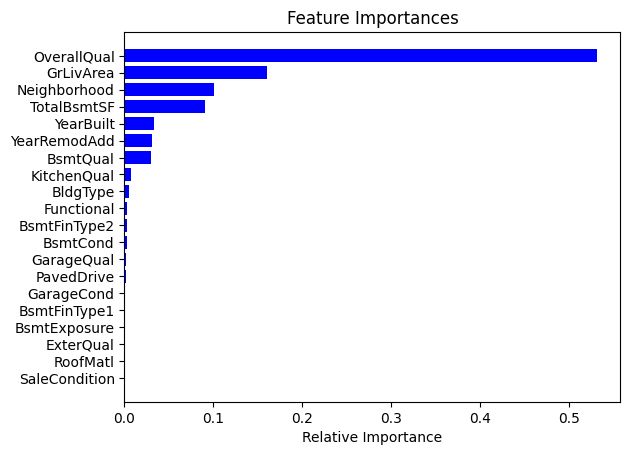

In [63]:
# Gráfica de importancia de las variables para el modelo Random Forest
features = X_train[variables_seleccionadas].columns
importances = modelo_seleccionado.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Diagnóstico de residuales

### Validación de normalidad

In [64]:
# Predicciones en el conjunto de entrenamiento
predicciones_entrenamiento = modelo_seleccionado.predict(X_train[variables_seleccionadas])

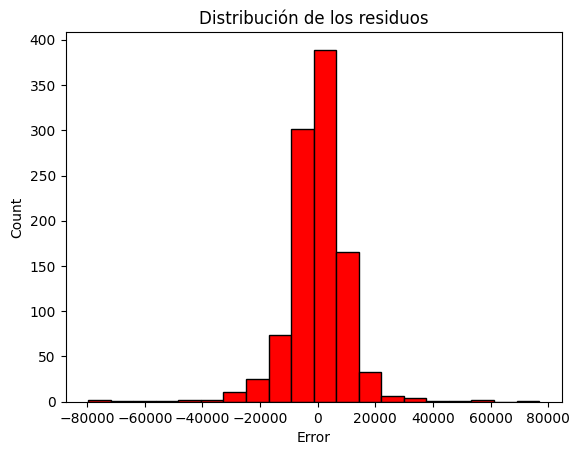

In [65]:
# Calcular los residuos
residuales = predicciones_entrenamiento - y_train

# Plot the residuals in a histogram
plt.hist(residuales, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribución de los residuos');

Los residuales parecen distribuirse normalmente, aunque hay algunos valores atípicos en las predicciones del valor de venta de algunas propiedades.

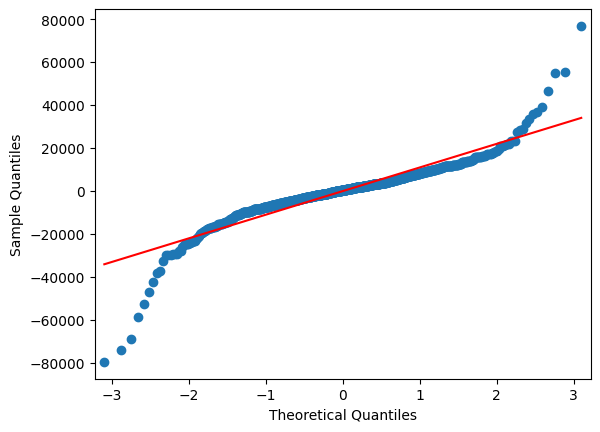

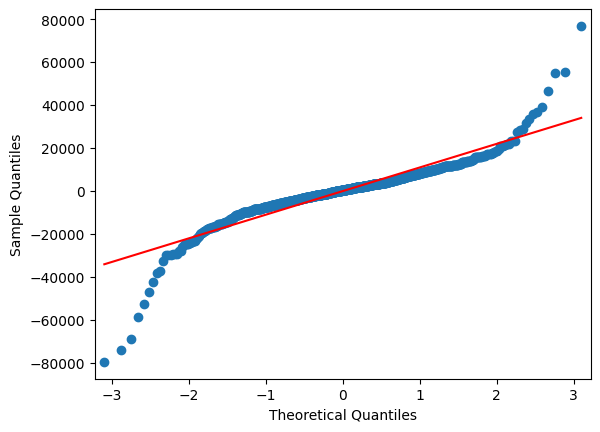

In [66]:
# QQ plot
sm.qqplot(residuales, line='s')

- **Hipótesis Nula (H0)**: Los residuos siguen una distribución normal.
- **Hipótesis Alternativa (H1)**: Los residuos no siguen una distribución normal.

In [67]:
# Normalidad de los residuos Shapiro-Wilk test
shapiro_test = stats.shapiro(residuales)
print(f"Test Shapiro-Wilk: estadístico = {shapiro_test[0]}, p-value = {shapiro_test[1]}")

Test Shapiro-Wilk: estadístico = 0.8699083452934205, p-value = 2.573101943443845e-28


A través del test analítico Shapiro-Wilk, donde el valor p < 0.05, se concluye que hay evidencia suficiente para afirmar que los residuales no se distribuyen de manera normal. Sin embargo, el mejor modelo es XGBoost y éste no requiere cumplir con supuestos de normalidad, por lo que sigue siendo válido. 

## Validación de homocedasticidad

- **Estadístico (fvalue)**: Este es el valor del estadístico de la prueba. Un valor más alto indica mayor evidencia en contra de la hipótesis nula.

- **p-value (f_p_value)**: Este valor indica la probabilidad de observar un estadístico tan extremo como el calculado, dado que la hipótesis nula es verdadera.

- **Si el p-value es menor que un nivel de significancia (por ejemplo, 0.05)**:
- **Rechazamos la hipótesis nula (H0)**. Esto sugiere que hay evidencia suficiente para concluir que hay heterocedasticidad en los residuos, es decir, la varianza de los errores no es constante.

- **Si el p-value es mayor que el nivel de significancia**:
- **No rechazamos la hipótesis nula (H0)**. Esto sugiere que no hay evidencia suficiente para concluir que hay heterocedasticidad, lo que implica que los residuos pueden considerarse homocedásticos.

<Axes: xlabel='SalePrice', ylabel='SalePrice'>

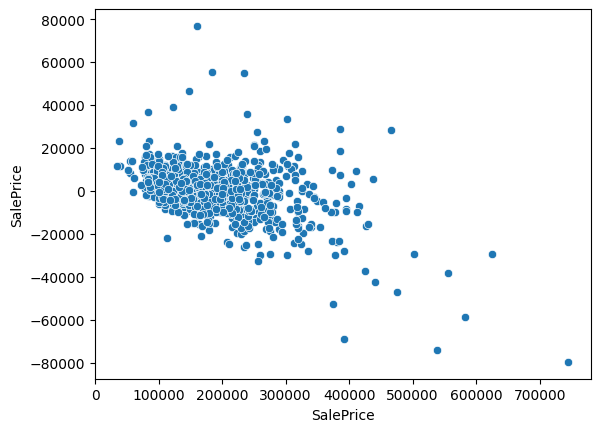

In [68]:
sns.scatterplot(x=y_train, y=residuales)

In [69]:
# Prueba de Breusch-Pagan
predictoras_constante = X_train[variables_seleccionadas]
predictoras_constante['Intercept'] = 1
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuales, predictoras_constante)
print(f"Estadítico= {fvalue}, p-value = {f_p_value}")

Estadítico= 11.148383253281837, p-value = 1.7862968411133467e-25


De acuerdo al test realizado, dado que el valor p < 0.05, hay evidencia suficiente para concluir que hay heterocedasticidad en los residuos, es decir, la varianza de los errores no es constante. Lo anterior puede deberse a la presencia de algunas propiedades con un precio de venta atípico.

# Interpretabilidad del modelo

In [71]:
explainer = shap.Explainer(modelo_seleccionado)
shap_values = explainer.shap_values(X_test)

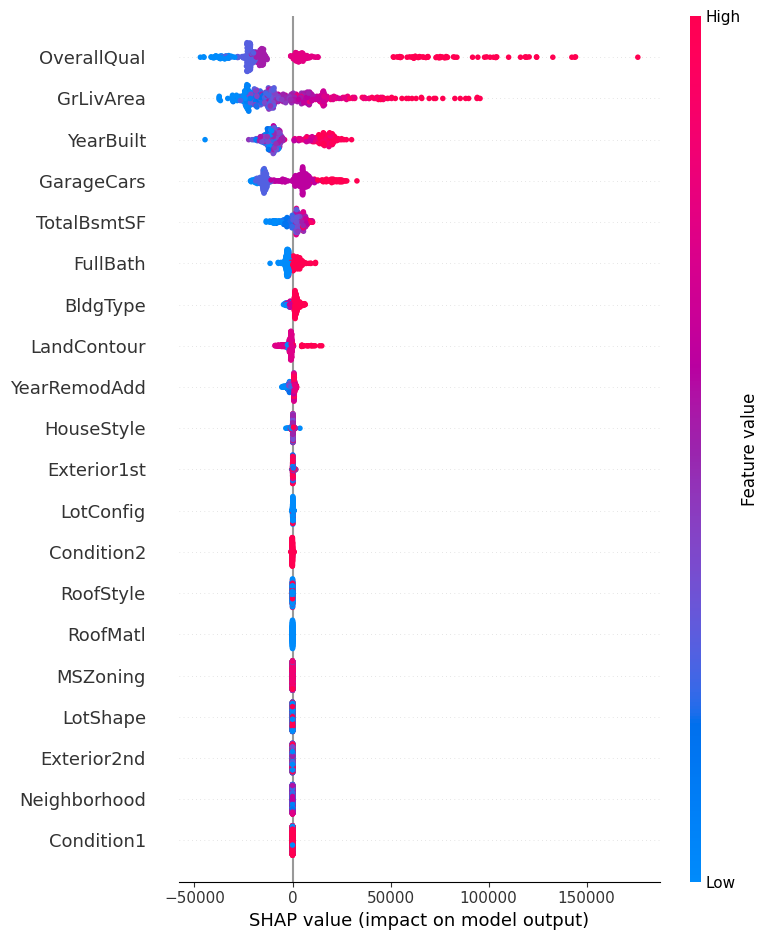

In [72]:
shap.summary_plot(shap_values, X_test)

Se puede mencionar que a mayor calidad total y mayor área, más alto será el precio de venta, además que entre más moderna sea la construcción, también mayor será su precio de venta.